In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
import time
warnings.filterwarnings("ignore")


In [13]:
heart = pd.read_csv('dataset/cardiovascular.txt',delimiter=';')
#heart = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')
#saturation = pd.read_csv ('dataset/o2Saturation.csv')

In [14]:
dataset = heart

In [15]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)


In [16]:
dataset = dataset.drop('ind', axis=1)
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
dataset['famhist']= label_encoder.fit_transform(dataset['famhist'])
dataset 

sbp  tobacco    ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0    160    12.00   5.73      23.11        1     49    25.30    97.20   52   
1    144     0.01   4.41      28.61        0     55    28.87     2.06   63   
2    118     0.08   3.48      32.28        1     52    29.14     3.81   46   
3    170     7.50   6.41      38.03        1     51    31.99    24.26   58   
4    134    13.60   3.50      27.78        1     60    25.99    57.34   49   
..   ...      ...    ...        ...      ...    ...      ...      ...  ...   
457  214     0.40   5.98      31.72        0     64    28.45     0.00   58   
458  182     4.20   4.41      32.10        0     52    28.61    18.72   52   
459  108     3.00   1.59      15.23        0     40    20.09    26.64   55   
460  118     5.40  11.61      30.79        0     64    27.35    23.97   40   
461  132     0.00   4.82      33.41        1     62    14.70     0.00   46   

     chd  
0      1  
1      1  
2      0  
3      1  
4      1  
..   ...  
457    0  
458    1  
459    0  
460    0  
461    1  

[462 rows x 10 columns]

In [17]:
dataset['chd'].value_counts()

0    302
1    160
Name: chd, dtype: int64

In [18]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [19]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

## Train the Support Vector Classifier

In [20]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    roc_10 = []
    cpu_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        roc_list = []
        cpu = []
        
        for train_ix, test_ix in kfold.split(X, y):

            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            t0= time.time()
            if (param == 0):
                model = SVC(probability=True)
                
            else:
                model = SVC(C=param['C'], gamma = param['gamma'], kernel= param['kernel'],probability=True )

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            #print(predictions)
            probs = model.predict_proba(X_test)
            #print(probs)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)
   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    
    return([accu,pre,spec,rec,f1,roc,cpu])



from sklearn.model_selection import cross_validate
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
model = SVC()
list_pre = []
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc'}
score = cross_validate(model,scaled_features,y,cv=10, scoring =scoring)
print(score['test_accuracy'].mean())


## Grid serach 

In [21]:

from sklearn.model_selection import GridSearchCV
def grid_search():
    
    param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
    grid = GridSearchCV(SVC(),param_grid,refit=True)
    # May take awhile!
    grid.fit(X_train,y_train)

    grid.best_params_
    return(grid.best_params_)


In [22]:
dict_SV = {}

## First Model without preprocessing 

In [12]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['SVM'] = result
dict_SV



{'SVM': [71.40101757631824,
  71.34342665200818,
  63.87324312397841,
  71.40101757631824,
  69.59163300291488,
  73.31324977402444,
  0.042094856897989905]}

## Hypertune model using grid search

In [13]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Hypertuned'] = result
dict_SV


{'SVM': [71.40101757631824,
  71.34342665200818,
  63.87324312397841,
  71.40101757631824,
  69.59163300291488,
  73.31324977402444,
  0.042094856897989905],
 'Hypertuned': [73.16790009250694,
  73.18638101103733,
  65.6275367720801,
  73.16790009250694,
  71.85482559048664,
  77.19556418585252,
  0.042033175627390534]}

## PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 4)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [15]:
pca.explained_variance_ratio_

array([0.32053161, 0.13301465, 0.11952794, 0.10496855])

In [16]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

<AxesSubplot:>

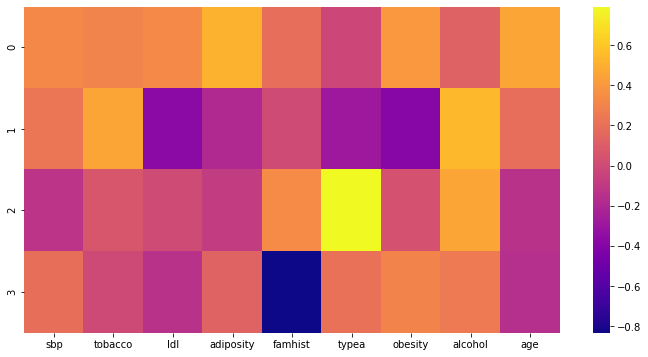

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [18]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401)
param = grid_search()
print(param)
result = calculate_model(param,X,y)
dict_SV['Pca'] = result
dict_SV


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


{'SVM': [71.40101757631824,
  71.34342665200818,
  63.87324312397841,
  71.40101757631824,
  69.59163300291488,
  73.31324977402444,
  0.042094856897989905],
 'Hypertuned': [73.16790009250694,
  73.18638101103733,
  65.6275367720801,
  73.16790009250694,
  71.85482559048664,
  77.19556418585252,
  0.042033175627390534],
 'Pca': [73.81837804502003,
  74.05295355309907,
  67.63121886283652,
  73.81837804502003,
  72.52884591696268,
  74.2648603758374,
  0.046777814229329424]}

## Feature Importance

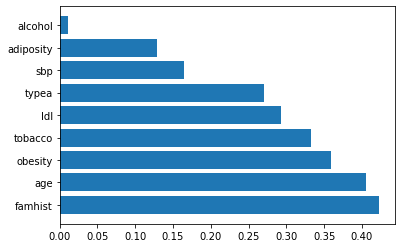

In [19]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

features_names = ['sbp','tobacco','ldl','adiposity','famhist','typea','obesity','alcohol','age']
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
f_importances(abs(svm.coef_[0]), features_names, top=9)


In [20]:

X = dataset[['famhist','age','obesity','tobacco','ldl','typea']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['FImp'] = result
dict_SV


{'SVM': [71.40101757631824,
  71.34342665200818,
  63.87324312397841,
  71.40101757631824,
  69.59163300291488,
  73.31324977402444,
  0.042094856897989905],
 'Hypertuned': [73.16790009250694,
  73.18638101103733,
  65.6275367720801,
  73.16790009250694,
  71.85482559048664,
  77.19556418585252,
  0.042033175627390534],
 'Pca': [73.81837804502003,
  74.05295355309907,
  67.63121886283652,
  73.81837804502003,
  72.52884591696268,
  74.2648603758374,
  0.046777814229329424],
 'FImp': [73.84967622571693,
  74.15753975445513,
  69.76933379801025,
  73.84967622571693,
  72.09971596373751,
  78.22857696731843,
  0.042392632166544604]}

## Permutation Importance


In [21]:
#pip install eli5

In [22]:
import eli5
from eli5.sklearn import PermutationImportance
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC(kernel='rbf')
svc.fit(X_train, y_train) 
# create permutation importance object using model
# and fit on test set
perm = PermutationImportance(svc, random_state=1).fit(X_test, y_test)
  
# display weights using PermutationImportance object
eli5.show_weights(perm, feature_names =['sbp','tobacco','ldl','adiposity','famhist','typea','obesity','alcohol','age'])

In [23]:

X = dataset[['famhist','age','alcohol','tobacco','ldl','typea']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Permutations'] = result
dict_SV


{'SVM': [71.40101757631824,
  71.34342665200818,
  63.87324312397841,
  71.40101757631824,
  69.59163300291488,
  73.31324977402444,
  0.042094856897989905],
 'Hypertuned': [73.16790009250694,
  73.18638101103733,
  65.6275367720801,
  73.16790009250694,
  71.85482559048664,
  77.19556418585252,
  0.042033175627390534],
 'Pca': [73.81837804502003,
  74.05295355309907,
  67.63121886283652,
  73.81837804502003,
  72.52884591696268,
  74.2648603758374,
  0.046777814229329424],
 'FImp': [73.84967622571693,
  74.15753975445513,
  69.76933379801025,
  73.84967622571693,
  72.09971596373751,
  78.22857696731843,
  0.042392632166544604],
 'Permutations': [72.8250077089115,
  72.88281971908587,
  65.34305101073679,
  72.8250077089115,
  71.49493616202832,
  77.57032150794605,
  0.047324720223744704]}

## Sequential Forward Selection

In [88]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=8, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(0, 1, 2, 3, 4, 5, 6, 7)
('0', '1', '2', '3', '4', '5', '6', '7')
CV Score:
0.7154387263976305


In [ ]:

feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SBS'] = result


In [76]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(0, 1, 2, 4, 5, 8)
('0', '1', '2', '4', '5', '8')
CV Score:
0.7018881895594224


In [ ]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SFS'] = result



## RFE

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

model=RandomForestClassifier()
rfe = RFE(model, n_features_to_select=5, step=1, verbose=2)
rfe = rfe.fit(X_train, y_train)
rfe.support_

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


array([False,  True,  True,  True, False, False,  True, False,  True])

In [29]:
#'age sex cp trtbps chol fbs restecg thalachh exng oldpeak slp caa thall output'
#'sbp','tobacco','ldl','adiposity','famhist','typea','obesity','alcohol','age'
X = dataset[['tobacco','ldl','adiposity','obesity','age']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['RFE'] = result

## K-means

In [30]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)


model = KMeans()
#visualizer = KElbowVisualizer(model, k=(1,12)).fit(scaled_features)
#visualizer.show()

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(scaled_features)

In [32]:
y= kmeans.predict(scaled_features)

In [41]:
df = pd.DataFrame(scaled_features , columns= ['sbp','tobacco','ldl','adiposity','famhist','typea','obesity','alcohol','age'])
#df['Cluster'] = y
df.head()

sbp   tobacco       ldl  adiposity   famhist     typea   obesity  \
0  1.058564  1.823073  0.478412  -0.295503  1.185854 -0.418470 -0.176786   
1  0.277089 -0.790237 -0.159680   0.412140 -0.843274  0.193344  0.671373   
2 -0.992806 -0.774980 -0.609245   0.884332  1.185854 -0.112563  0.735519   
3  1.546985  0.842264  0.807126   1.624141  1.185854 -0.214532  1.412621   
4 -0.211332  2.171805 -0.599577   0.305351  1.185854  0.703189 -0.012856   

    alcohol       age  
0  3.277738  0.629336  
1 -0.612745  1.383115  
2 -0.541183  0.218184  
3  0.295062  1.040488  
4  1.647775  0.423760

In [34]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_features)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [42]:
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans'] = result

In [43]:
import shap

In [44]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)

[17:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


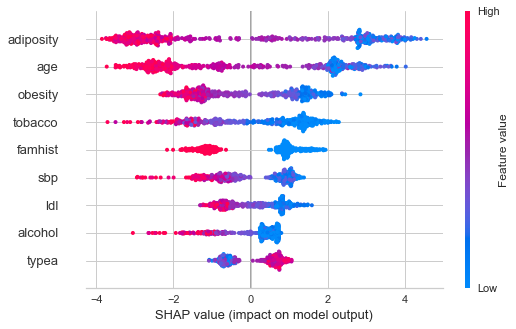

In [45]:
shap.plots.beeswarm(shap_values)

In [48]:

X = dataset[['sbp','tobacco','adiposity','famhist','obesity','ldl','age','alcohol']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans+Shap'] = result
result

[97.96592661116249,
 98.08798132616977,
 96.43254320541239,
 97.96592661116249,
 97.97069146661192,
 99.90526311479691,
 0.011801336606343587]

In [ ]:
df_dict = pd.DataFrame.from_dict(dict_SV,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

In [50]:
#df_dict.to_excel('xl_result\SVM_SA_30.xlsx')

In [91]:
#df_dict =  pd.read_excel('xl_result/SVM_SA_30.xlsx',index_col=0)

In [92]:
# Adding Number of features
df_dict['no_of_features'] = [9,9,'4 components',6,6,8,6,5,9,8]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM           71.401018  71.343427    63.873243  71.401018  69.591633   
Hypertuned    73.167900  73.186381    65.627537  73.167900  71.854826   
Pca           73.818378  74.052954    67.631219  73.818378  72.528846   
FImp          73.849676  74.157540    69.769334  73.849676  72.099716   
Permutations  72.825008  72.882820    65.343051  72.825008  71.494936   
SBS           71.223404  71.304354    65.785943  71.223404  68.610342   
SFS           73.636756  73.999404    68.031854  73.636756  72.201790   
RFE           70.517114  70.477425    62.622416  70.517114  68.483987   
kmeans        97.777521  97.930879    96.021841  97.777521  97.781707   
kmeans+Shap   97.965927  98.087981    96.432543  97.965927  97.970691   

                    Roc  CPU_time no_of_features  
SVM           73.313250  0.042095              9  
Hypertuned    77.195564  0.042033              9  
Pca           74.264860  0.046778   4 components  
FImp          78.228577  0.042393              6  
Permutations  77.570322  0.047325              6  
SBS           72.171224  0.042218              8  
SFS           77.836570  0.039666              6  
RFE           74.995375  0.041342              5  
kmeans        99.919840  0.012134              9  
kmeans+Shap   99.905263  0.011801              8